# Functions, Function-sets, Function-spaces, and Function datasets
This notebook gives and introduction into function datasets in continuity. Due to their simplicity, these datasets can be used to explore different properties of operators.

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import matplotlib.pyplot as plt
from continuity.data.function import Function, ParameterizedFunction, SampledFunctionSet, FunctionSet
from continuity.discrete import RegularGridSampler, UniformBoxSampler
from continuity.data.function_dataset import FunctionOperatorDataset

In [28]:
x_plot = torch.linspace(-1, 1, 300)

## Functions
Functions are the basic building block form which the following concepts (parameterized functions, function sets, and function operator datasets) are built. A function $f$ is a mapping that takes a single input $x\in\mathbb{R}^n$ and maps it onto $y\in\mathbb{R}^m$
$$
f: x\mapsto f(x)=y.
$$

In continuity this mapping can be described by creating a `Funciton` object, that takes a callable (that can be evaluated with only one variable) as input. Defining the sine function becomes.

In [29]:
sine = Function(lambda x: torch.sin(torch.pi * x))

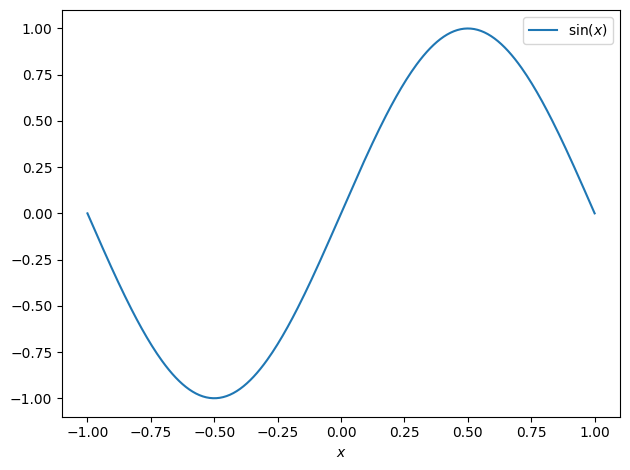

In [30]:
plt.plot(x_plot, sine(x_plot), label="$\sin(x)$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()

Function objects can be added to, subtracted from, multiplied with, or divided by other function instances, to gain a new function.

In [31]:
sine = Function(lambda x: torch.sin(torch.pi * x))
poly = Function(lambda x: x ** 3)

f_sum = sine + poly
f_prod = sine * poly
f_sub = sine - poly
f_div = sine / poly

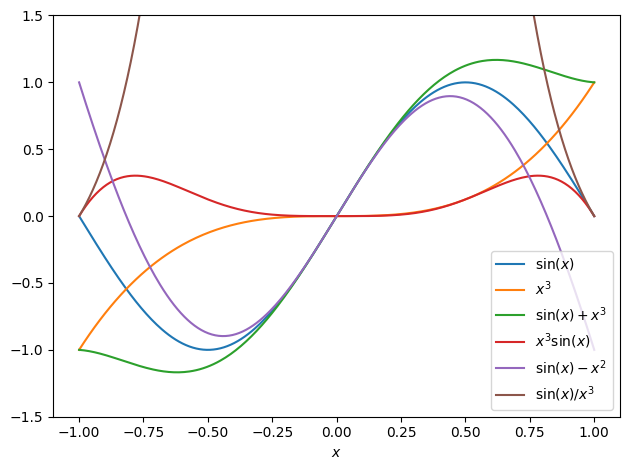

In [32]:
plt.plot(x_plot, sine(x_plot), label="$\sin(x)$")
plt.plot(x_plot, poly(x_plot), label="$x^3$")
plt.plot(x_plot, f_sum(x_plot), label="$\sin(x)+x^3$")
plt.plot(x_plot, f_prod(x_plot), label="$x^3\sin(x)$")
plt.plot(x_plot, f_sub(x_plot), label="$\sin(x) - x^2$")
plt.plot(x_plot, f_div(x_plot), label="$\sin(x) / x^3$")
plt.ylim(-1.5, 1.5)
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()

## Parameterized Functions
The concept of functions is extended by parameterized functions. Parameterized functions are functions that map the space $x\in\mathbb{R}^n$ and the parameter space $a\in\mathbb{R}^{n_p}$ onto $y\in\mathbb{R}^m$
$$
f_a: a, x\mapsto f(a, x)=y.
$$
This mapping can be understood as an operator $\mathcal{G}$ mapping a parameter space onto a set of functions
$$
\mathcal{G}:\mathcal{A}\rightarrow \mathcal{U},
$$
where $\mathcal{A}$ is the vector space of parameters and $\mathcal{U}$ a function set.

Crating these parameterized functions is described below. Evaluating them with a set of parameters yields a list of functions.

In [33]:
p_sine = ParameterizedFunction(lambda a, x: a[0] * torch.sin(a[1] * x + a[2]), n_parameters=3)

n_observations = 4
parameters = 8 * torch.pi * (torch.rand((n_observations, 3, 1)) - .5)
sines = p_sine(parameters)

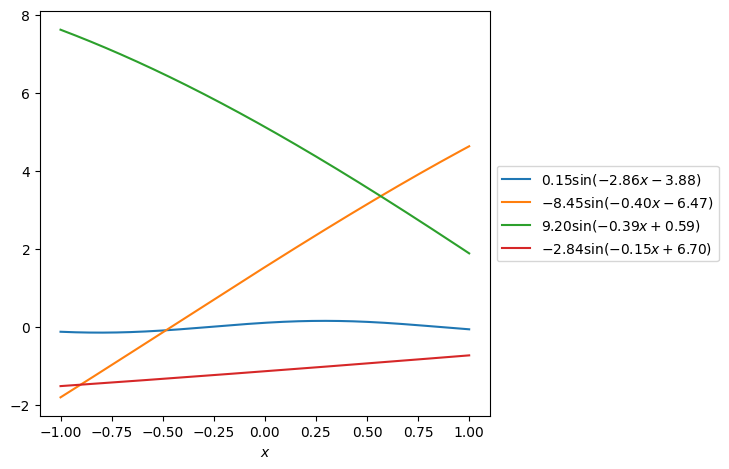

In [34]:
fig, ax = plt.subplots()
for sine, param in zip(sines, parameters):
    param = param.tolist()
    param = [p[0] for p in param]
    plt.plot(x_plot, sine(x_plot), label=f"${param[0]:.2f}\sin({param[1]:.2f}x{param[2]:+.2f})$")
plt.xlabel("$x$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

Parameterized functions can be added, subtracted, multiplied, or divided to/from/by/...with other parameterized functions. The resulting parameterized function has as many parameters as the sum of parameters of the two parameterized functions. Adding/multiplying a function with 3 parameters onto/with a function with 4 parameters results in a function parameterized in 7 variables.  

In [35]:
p_sine = ParameterizedFunction(lambda a, x: a[0] * torch.sin(a[1] * x + a[2]), n_parameters=3)
p_poly = ParameterizedFunction(lambda a, x: a[0] * (x - a[1]) ** a[2], n_parameters=3)

p_f_sum = p_sine + p_poly
p_f_minus = p_sine - p_poly
p_f_prod = p_sine * p_poly
p_f_div = p_sine / p_poly

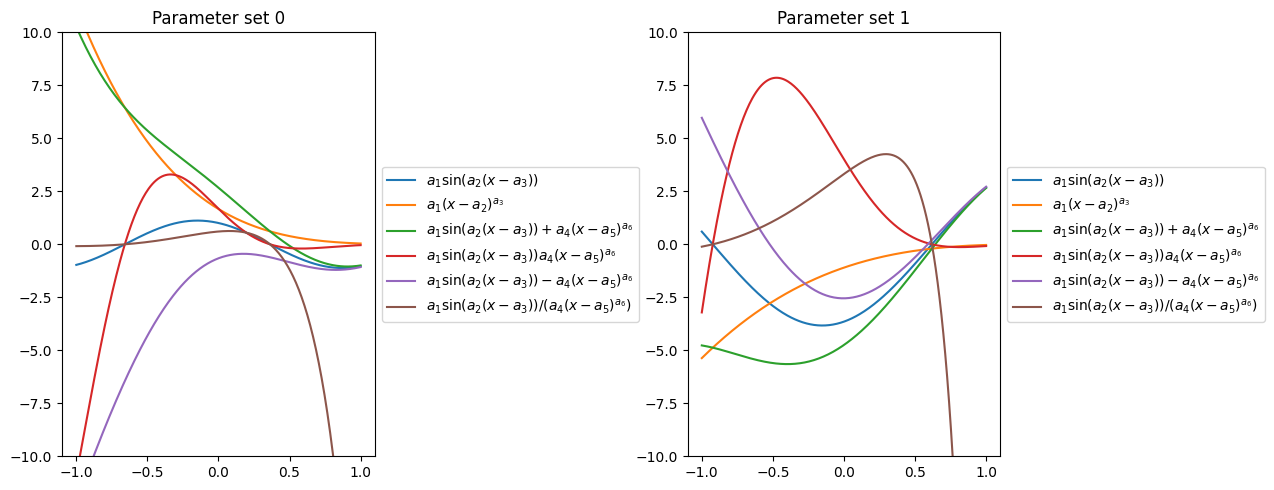

In [36]:
n_observations = 2
parameters_sin = 2 * torch.pi * (torch.rand((n_observations, 3, 1)) - 1.)
parameters_poly = 2 * torch.rand((n_observations, 3, 1))
parameters_poly[:, 2, :] = torch.randint(2, 5, (n_observations, 1)).to(torch.get_default_dtype())  # integer exponent

sines = p_sine(parameters_sin)
polys = p_poly(parameters_poly)
sums =  p_f_sum(torch.cat([parameters_sin, parameters_poly], dim=1))
prods =  p_f_prod(torch.cat([parameters_sin, parameters_poly], dim=1))
minus =  p_f_minus(torch.cat([parameters_sin, parameters_poly], dim=1))
divs =  p_f_div(torch.cat([parameters_sin, parameters_poly], dim=1))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, (fs, fp, fss, fps, fms, fds) in enumerate(zip(sines, polys, sums, prods, minus, divs)):
    ax[i].plot(x_plot, fs(x_plot), label="$a_1\sin(a_2(x-a_3))$")
    ax[i].plot(x_plot, fp(x_plot), label="$a_1 (x - a_2)^{a_3}$")
    ax[i].plot(x_plot, fss(x_plot), label="$a_1\sin(a_2(x-a_3)) + a_4 (x - a_5)^{a_6}$")
    ax[i].plot(x_plot, fps(x_plot), label="$a_1\sin(a_2(x-a_3)) a_4 (x - a_5)^{a_6}$")
    ax[i].plot(x_plot, fms(x_plot), label="$a_1\sin(a_2(x-a_3)) - a_4 (x - a_5)^{a_6}$")
    ax[i].plot(x_plot, fds(x_plot), label=r"$a_1\sin(a_2(x-a_3)) / \left(a_4 (x - a_5)^{a_6}\right)$")
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].title.set_text(f"Parameter set {i}")
    ax[i].set_ylim(-10, 10)
plt.tight_layout()
plt.subplots_adjust(wspace=1.)

## Function Set

This parameterized function is used to create function sets. For function sets only the plus and minus operator are defined. Using a `Sampler` a `FunctionSet` can be transferred into a `SampledFunctionSet` holding only a set of `Function` instead of a `ParameterizedFunction`. 

In [37]:
n_observations = 42
p_sine = ParameterizedFunction(lambda a, x: a[0] * torch.sin(a[1] * x + a[2]), n_parameters=3)
space = FunctionSet(p_sine)
sampler = UniformBoxSampler(torch.tensor([1., torch.pi, 0.]), torch.tensor([2., 2 * torch.pi, 0.]))
samples = sampler(n_observations)
sampled_space = SampledFunctionSet(function_set=space, samples=samples)

print(f"Number of functions inside the sampled function set: {len(sampled_space.functions)}")

Number of functions inside the sampled function set: 42


## Function Operator Dataset

A general operator mapping $\mathcal{G}: \mathcal{A}\rightarrow\mathcal{U}$ is supported on two function spaces $\mathcal{A}$ and $\mathcal{U}$. Here we assume that $\mathcal{A}$ and $\mathcal{U}$ be Banach spaces respectively of functions defined on bounded domains $D_a\subset \mathbb{R}^n$ and $D_u\subset\mathbb{R}^m$ respectively. Operator datasets are discrete instances of these function spaces. 
Thus, sampling from both domains and both function spaces is required. Here we assume that not all parameterized functions produce valid function spaces, motivating the term `FunctionSet`.

This first example describes how to create a dataset from function set of sine functions. The operator implemented here is the differential operator, namely:
$$
\mathcal{G}:C^1(M)\rightarrow C^0(M)
$$
The solution operator $\mathcal{G}^\dag_a$ for these specific functions is
$$
\mathcal{G}^\dag_a: a_1\sin\left(a_2 (x - a_3)\right) \rightarrow a_1a_2\cos\left(a_2 (x - a_3)\right).
$$
Here we will create a dataset that has been sampled with 10 sensors and 300 evaluations. The sampler for $x$ and $y$ is the same as the domain in the input, and the solution space is the same. The way all of these functions are sampled can be changed by changing the sampler for the matching variable.

In [38]:
p_sine = ParameterizedFunction(lambda a, x: a[0] * torch.sin(a[1] * x + a[2]), n_parameters=3)
p_d_sine = ParameterizedFunction(lambda a, x: a[0] * a[1] * torch.cos(a[1] * x + a[2]), n_parameters=3)

input_space = FunctionSet(p_sine)
solution_space = FunctionSet(p_d_sine)
parameter_sampler = UniformBoxSampler(torch.tensor([1., torch.pi, 0.]), torch.tensor([2., 2 * torch.pi, torch.pi]))
space_sampler = RegularGridSampler(torch.tensor([-1.]), torch.tensor([1.]))

n_observations = 9
data = FunctionOperatorDataset(
    input_function_set=p_sine,
    x_sampler=space_sampler,
    n_sensors=10,
    solution_function_set=p_d_sine,
    y_sampler=space_sampler,
    n_evaluations=300,
    p_sampler=parameter_sampler,
    n_observations=n_observations
)

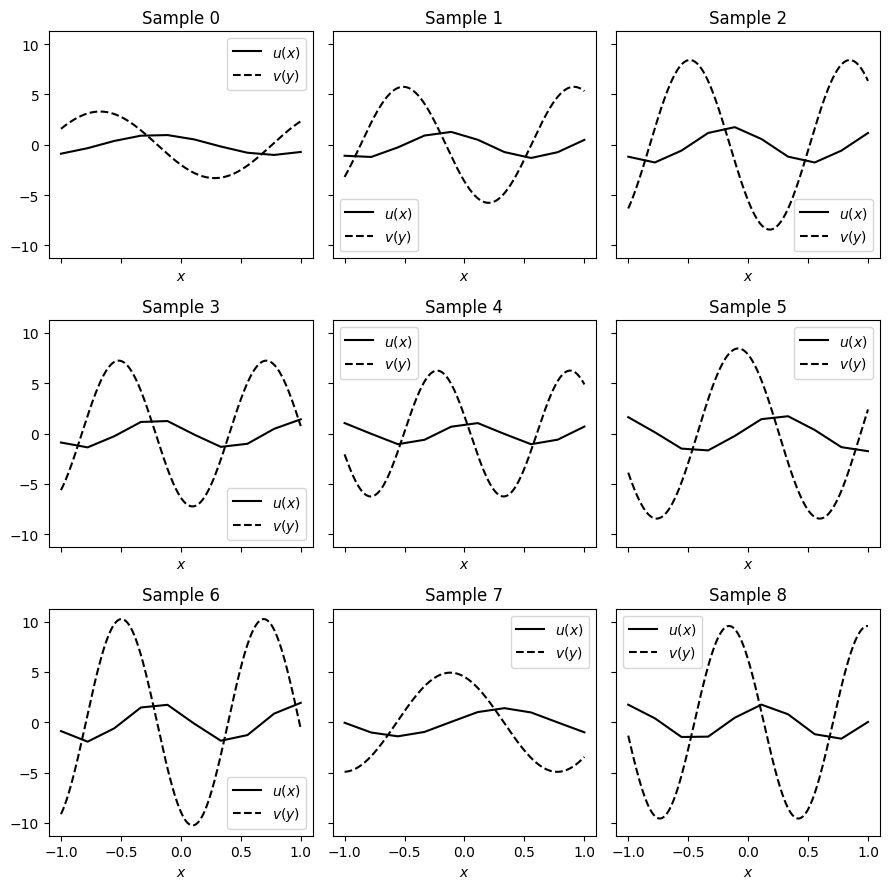

In [39]:
nax = int(n_observations ** .5)
fig, ax = plt.subplots(nax, nax, sharex=True, sharey=True, figsize=(3 * nax, 3 * nax))
for i, (x, u, y, v) in enumerate(data):
    row, col = i // nax, i % nax
    ax[row, col].plot(x, u, 'k-', label=f"$u(x)$")
    ax[row, col].plot(y, v, 'k--', label=f"$v(y)$")
    ax[row, col].title.set_text(f"Sample {i}")
    ax[row, col].set_xlabel("$x$")
    ax[row, col].legend()
plt.tight_layout()